In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'ex4.ipynb',
 'Ex4_data_preparation-R.ipynb',
 'exercise_04.pdf',
 'spambase.data.txt',
 'spambase.DOCUMENTATION.txt',
 'spambase.names.txt',
 'spam_base_test.csv',
 'spam_base_train.csv']

In [3]:
dataframe = pd.read_csv('spam_base_train.csv')

In [4]:
def load_data(filename):
    # Split dataframe into X and Y numpy arrays, add 1 padding to X
    dataframe = pd.read_csv(filename)
    X = np.array(dataframe, dtype = 'float64')[:,:-1]
    X = np.pad(X,1,'constant',constant_values=(1))[1:X.shape[0]+1,0:X.shape[1]+1]
    Y = np.array(dataframe, dtype = 'int')[:,-1:]
    
    return (X, Y)

In [5]:
X_train, Y_train = load_data('spam_base_train.csv')
X_train.shape

(3221, 58)

<h2>Logit model from exercise 3</h2>

In [6]:
def get_likelihood(cross_product):
    return 0.5 + 0.5 * np.tanh(cross_product / 2)

In [7]:
def train_logit(X, Y, acc_const = 0.00001):
    const = 0.00001
    teta = np.zeros([X.shape[1], 1], dtype = 'float64')

    likelihood_old = 1.
    converge_idx = 1.

    while converge_idx > 0.00001:
        cross_product = X.dot(teta)
        hteta = np.apply_along_axis(get_likelihood, 0,cross_product)
        likelihood = np.transpose(Y).dot(cross_product) - sum(np.ones([cross_product.shape[0],1]) -  np.exp(cross_product))
        converge_idx = (likelihood_old - likelihood) / likelihood_old
        deriva = np.transpose(X).dot(Y - hteta)
        
        if converge_idx <= 0.0001:
            break
        
        teta = teta + const * deriva

    return teta

In [9]:
def logit_predict(x, coef):
    cross_product = x.dot(coef)
    return get_likelihood(cross_product)

<h2> Apply model & Report F Measure</h2>

In [10]:
coef = train_logit(X_train, Y_train)
np.transpose(coef)

array([[-0.02805595,  0.00205158, -0.00914315,  0.00573615,  0.00692994,
         0.01310739,  0.00573449,  0.01469252,  0.00818826,  0.00636297,
         0.00328708,  0.00435962, -0.01548288,  0.00197417,  0.00035848,
         0.00553423,  0.02280241,  0.01124735,  0.00971271,  0.01531798,
         0.01103123,  0.03686321,  0.00787759,  0.01297281,  0.01057831,
        -0.06898876, -0.03335918, -0.07706435, -0.01466624, -0.01214646,
        -0.01290086, -0.00872363, -0.00583337, -0.01216267, -0.00581915,
        -0.01379408, -0.01024531, -0.01404293, -0.00128035, -0.00997825,
        -0.00480489, -0.00620655, -0.01791639, -0.00545112, -0.01150035,
        -0.02655583, -0.02330925, -0.00060838, -0.00433375, -0.00374318,
        -0.00758666, -0.00152014,  0.01905912,  0.00816083,  0.00258316,
         0.01202989,  0.0267935 ,  0.0332524 ]])

In [11]:
X_test, Y_test = load_data('spam_base_test.csv')
X_test.shape

(1380, 58)

In [12]:
Y_hat = np.array([logit_predict(X_test[idx,:], coef) for idx in range(0,X_test.shape[0])])
Y_hat = Y_hat.round()
acc = sum(Y_hat == Y_test) / Y_test.shape[0]
acc

array([ 0.85724638])

In [13]:
def F_score(Y, Y_hat, beta):
    true_positives = sum(np.logical_and(Y == True , Y_hat == True))
    false_positives = sum(np.logical_and(Y == False , Y_hat == True))
    false_negatives = sum(np.logical_and(Y == True , Y_hat == False))
    
    precision =  true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    F = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)
    
    return F[0]

In [14]:
F_beta = np.array([[beta , F_score(Y_test, Y_hat, beta)] for beta in np.arange(0.5, 1.01, 0.05)])
F_beta

array([[ 0.5       ,  0.80333333],
       [ 0.55      ,  0.80614944],
       [ 0.6       ,  0.80900429],
       [ 0.65      ,  0.81186577],
       [ 0.7       ,  0.81470642],
       [ 0.75      ,  0.81750339],
       [ 0.8       ,  0.82023824],
       [ 0.85      ,  0.82289653],
       [ 0.9       ,  0.82546741],
       [ 0.95      ,  0.82794315],
       [ 1.        ,  0.83031869]])

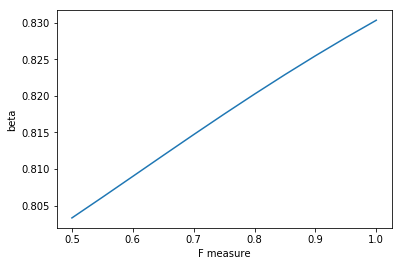

In [15]:
plt.plot(F_beta[:,0], F_beta[:,1])
plt.xlabel('F measure')
plt.ylabel('beta')
plt.show()

# Logistic Ridge Regression

In [16]:
def train_ridge_logit(X, Y, l):
    const = 0.00001
    theta = np.zeros([X.shape[1],1], dtype = 'float64')

    likelihood_old = 1.
    converge_idx = 1.

    while converge_idx > 0.00001:

        cross_product = X.dot(theta)
        htheta = np.apply_along_axis(get_likelihood, 0,cross_product)
        delta = l * np.sum(np.square(theta))
        likelihood = np.transpose(Y).dot(cross_product) - sum(np.ones([cross_product.shape[0],1]) - np.exp(cross_product)) - delta
        converge_idx = (likelihood_old - likelihood) / likelihood_old
        deriva = np.transpose(X).dot(Y - htheta)
        
        if converge_idx <= 0.0001:
            break
        
        theta = theta + const * deriva

    return (theta, delta)

For the logistic ridge regression we introduce a new parameter `l`, which is usually denoted as lambda. This controls the penality added on top of the likelihood. The penality itself is the squared euclidean norm of the theta vector. Because the euclidian norm is a square root itself, we transformed the formula for better numerical stability.

In [17]:
coefRidge = train_ridge_logit(X_train, Y_train, 5)
np.transpose(coefRidge[0])

array([[-0.02805595,  0.00205158, -0.00914315,  0.00573615,  0.00692994,
         0.01310739,  0.00573449,  0.01469252,  0.00818826,  0.00636297,
         0.00328708,  0.00435962, -0.01548288,  0.00197417,  0.00035848,
         0.00553423,  0.02280241,  0.01124735,  0.00971271,  0.01531798,
         0.01103123,  0.03686321,  0.00787759,  0.01297281,  0.01057831,
        -0.06898876, -0.03335918, -0.07706435, -0.01466624, -0.01214646,
        -0.01290086, -0.00872363, -0.00583337, -0.01216267, -0.00581915,
        -0.01379408, -0.01024531, -0.01404293, -0.00128035, -0.00997825,
        -0.00480489, -0.00620655, -0.01791639, -0.00545112, -0.01150035,
        -0.02655583, -0.02330925, -0.00060838, -0.00433375, -0.00374318,
        -0.00758666, -0.00152014,  0.01905912,  0.00816083,  0.00258316,
         0.01202989,  0.0267935 ,  0.0332524 ]])

Coefficients for a lambda of 5

In [18]:
def k_fold(X_train, i, k):
    if i >= k:
        raise ValueError('invalid value for i')
    
    chunk = int(X_train.shape[0] / k)
    remain = X_train.shape[0] % k
    
    start = int(chunk * i)
    stop = int(start + chunk)
    
    if (i + 1) == k:
        stop = int(stop + remain)
    
    return (X_train[start:stop], np.append(X_train[0:start], X_train[stop:], axis=0))

The inner k-folding function calculates chunk sizes based on the k splits and the given dataset size. It then returns the desired chunk denoted by `i` and merges the remaining data points a second set. In cross validation, the chunk is used for validation while the remainder is used for training.

In [19]:
def cross_ridge_logit(X_train, Y_train, X_test, Y_test):
    deltas = []
    f_scores = []
    
    for l in np.arange(1, 500, 10):
        coefSum = np.zeros([X_train.shape[1], 1])
        deltaSum = 0
        
        for i in range(4, -1, -1):
            X_validation, X_train_local = k_fold(X_train, i, 5)
            Y_validation, Y_train_local = k_fold(Y_train, i, 5)
            
            coefRidge, delta = train_ridge_logit(X_train_local, Y_train_local, l)
            coefSum = coefSum + coefRidge
            deltaSum = deltaSum + delta
        
        coef = coefSum / 5
        Y_hat = np.array([logit_predict(X_test[idx, :], coef) for idx in range(0, X_test.shape[0])]).round()
        
        deltas.append([l, deltaSum / 5])
        f_scores.append([l, F_score(Y_test, Y_hat, 0.5)])
    
    return (coef, deltas, f_scores)

Using `k_fold()` this the crossvalidating implementation of thelogistic ridge regression iterates over a range of possible lambda values. For each lamba, a 5-fold cross validation is executed by calculating the coefficients for each of the 5 combinations of the chunk and remainder out of the train dataset. We let lambda range from 1 to 100.

In [20]:
out = cross_ridge_logit(X_train, Y_train, X_test, Y_test)

We now calculate the 5-fold cross validated logistic ridge regression and plot the parameters, using a F Score with beta of 0.5.

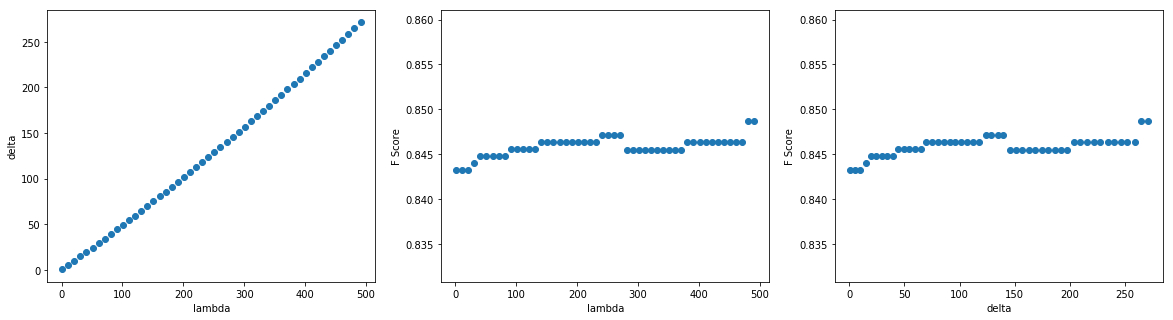

In [23]:
plt.figure(1, figsize=(20, 5))

plt.subplot2grid((1, 3), (0, 0))
plt.scatter(
    np.array(out[1]).T[0],
    np.array(out[1]).T[1],
)
plt.xlabel('lambda')
plt.ylabel('delta')

plt.subplot2grid((1, 3), (0, 1))
plt.scatter(
    np.array(out[2]).T[0],
    np.array(out[2]).T[1],
)
plt.xlabel('lambda')
plt.ylabel('F Score')

plt.subplot2grid((1, 3), (0, 2))
plt.scatter(
    np.array(out[1]).T[1],
    np.array(out[2]).T[1],
)
plt.xlabel('delta')
plt.ylabel('F Score')

plt.show()